### Import modules

In [1]:
import os
import pickle

from os.path import isdir, join
from pathlib import Path

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.utils import to_categorical

from sklearn.model_selection import KFold, train_test_split

/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seongjinpark/.conda/envs/pyt

In [2]:
tf.test.is_gpu_available()

True

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Check the location of WAV files

In [6]:
!ls ../audio/wavs

S02_Almost-All-Colleges.wav	     S19_Military-Personnel-Are.wav
S02_A-Monstrous-Shadow.wav	     S19_Nothing-Has-Been.wav
S02_An-Adult-Male.wav		     S19_Of-Course-Dear.wav
S02_Any-Organism-That.wav	     S19_Only-The-Most.wav
S02_Are-You-Looking.wav		     S19_Pam-Gives-Driving.wav
S02_Before-Thursdays-Exam.wav	     S19_Ralph-Prepared-Red.wav
S02_Carl-Lives-In.wav		     S19_She-Had-Your.wav
S02_Combine-All-The.wav		     S19_Steve-Collects-Rare.wav
S02_Continental-Drift-Is.wav	     S19_The-Moisture-In.wav
S02_Did-Shawn-Catch.wav		     S19_The-Small-Boy.wav
S02_Dont-Ask-Me.wav		     S19_The-Surplus-Shoes.wav
S02_Gently-Place-Jims.wav	     S19_The-Tooth-Fairy.wav
S02_George-And-Tom.wav		     S19_They-All-Like.wav
S02_Gregory-And-Tom.wav		     S19_They-Enjoy-It.wav
S02_He-Ate-Four.wav		     S19_They-Were-Already.wav
S02_He-Shrugged-Casually.wav	     S19_Those-Answers-Will.wav
S02_How-Oily-Do.wav		     S19_Thus-Technical-Efficiency.wav
S02_How-Permanent-Are.wav	     S19_Too-Much-Curiosity.wav

### Check wav files

In [4]:
audio_path = '../audio/wavs/'
print(os.listdir(audio_path)[:10])

['S09_He-Ate-Four.wav', 'S26_Those-Answers-Will.wav', 'S28_Try-To-Recall.wav', 'S03_Thus-Technical-Efficiency.wav', 'S25_Try-To-Recall.wav', 'S02_A-Monstrous-Shadow.wav', 'S21_A-Monstrous-Shadow.wav', 'S04_The-Small-Boy.wav', 'S28_Gently-Place-Jims.wav', 'S21_Military-Personnel-Are.wav']


### Extract mel-spectrogram and mfcc features

In [5]:
wav2idx = {}
melspec_dict = {}
mfcc_dict = {}

wav_names = [wav for wav in os.listdir(audio_path) if wav.endswith("wav")]

samples = 132300
max_len = 0

for i, w in enumerate(wav_names):
    wav2idx[w] = i
    wav_path = audio_path + w
    
    y, sr = librosa.load(wav_path) 
    
#     sample = sr * 5
    
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)

    if len(y) > samples: # long enough
        y = y[0:0+samples]

    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    
    
    mel_data = librosa.feature.melspectrogram(y = y, sr= sr)
    mfcc_data = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13)
    mfcc_delta = librosa.feature.delta(mfcc_data)
    mfcc_delta2 = librosa.feature.delta(mfcc_data, order = 2)

    mfcc = np.vstack((mfcc_data, mfcc_delta, mfcc_delta2))
#     if (np.shape(mel_data)[1] > max_len):
#         max_len = np.shape(mel_data)[1] 
    
    melspec_dict[i] = mel_data
    mfcc_dict[i] = mfcc

### Check the shape

In [6]:
print(max_len)
print(sr * 5)
for i in list(melspec_dict.keys())[:10]:
    print(melspec_dict[i].shape)

0
110250
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)


In [7]:
with open("../data/fluency_data.csv", "r") as f:
    data = f.readlines()

In [8]:
X = []
Y = []
X_wav = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)
    
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = mfcc_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(Y))
print()

(11100, 39, 259)
(11100,)


In [9]:
kf = KFold(n_splits = 10)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [19]:
# reshape
X = np.array(X)
Y = np.array(Y)
X_wav = np.array(X_wav)
print(np.shape(X))
print(np.shape(X_wav))


(11100, 39, 259)
(11100,)


In [20]:
for train_index, test_index in kf.split(X):
    print("TRAIN: ", X_wav[train_index])
    print("TRAIN: ", Y[test_index])

TRAIN:  [299  55 356 ... 497 577 529]
TRAIN:  [2 3 3 ... 2 5 3]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [4 5 5 ... 1 5 3]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [5 4 3 ... 3 3 3]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [5 2 3 ... 1 0 2]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [5 3 2 ... 5 5 4]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [2 1 3 ... 5 3 3]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [5 1 4 ... 1 4 4]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [4 3 1 ... 3 5 5]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [3 4 2 ... 5 5 5]
TRAIN:  [400 363 111 ... 580 130 340]
TRAIN:  [5 5 5 ... 0 0 3]


In [12]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_mel = np.shape(X)[1]
max_time = np.shape(X)[2]

In [13]:
input_shape = (num_mel, max_time)

model = Sequential()

model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_mel, max_time)))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(drop_out_rate))
model.add(Dense(num_dense_unit))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model.compile(optimizer=adam, loss="mse", metrics=["mse"])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 39, 1024)          3162112   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,753,089
T

In [14]:
from datetime import datetime
logdir = "logs/scalars/CV" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [15]:
CV_mse = []
CV_histories = []
CV_prediction = []

In [22]:
num_epochs = 40

cv_idx = 1
for train_index, test_index in kf.split(X):
    model_name = "../data/CV_rnn_mfcc_40_CV%d.h5" % (cv_idx)
#     model.load_weights(model_name)
    X_train, X_test = X[train_index], X[test_index]
    X_train_wav, X_test_wav = X_wav[train_index], X_wav[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False,
                       class_weight = None, verbose = 1, validation_data = (X_test, y_test), 
                       callbacks = [tensorboard_callback])
    CV_histories.append(history)
            
    model.save(model_name)
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    CV_mse.append(scores[1])
    y_prediction = model.predict(X_test)
    
    for i in range(len(y_test)):
        result = "%d\t%s\t%d\t%f\n" % (cv_idx, wav_names[X_test_wav[i]], y_test[i], y_prediction[i][0])
#         print(result)
        CV_prediction.append(result)
    
    cv_idx += 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9990 samples, validate on 1110 samples


Epoch 1/40
9990/9990 [==============================] - 25s 2ms/step - loss: 3.1789 - mean_squared_error: 3.1789 - val_loss: 1.2012 - val_mean_squared_error: 1.2012
Epoch 2/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.5818 - mean_squared_error: 1.5818 - val_loss: 0.9490 - val_mean_squared_error: 0.9490
Epoch 3/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.4510 - mean_squared_error: 1.4510 - val_loss: 0.8636 - val_mean_squared_error: 0.8636
Epoch 4/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.3744 - mean_squared_error: 1.3744 - val_loss: 0.8523 - val_mean_squared_error: 0.8523
Epoch 5/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.3662 - mean_squared_error: 1.3662 - val_loss: 0.8378 - val_mean_squared_error: 0.8378
Epoch 6/40
9990/9990 [=========

9990/9990 [==============================] - 23s 2ms/step - loss: 1.0901 - mean_squared_error: 1.0901 - val_loss: 1.3573 - val_mean_squared_error: 1.3573
Epoch 6/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0916 - mean_squared_error: 1.0916 - val_loss: 1.3834 - val_mean_squared_error: 1.3834
Epoch 7/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0963 - mean_squared_error: 1.0963 - val_loss: 1.2629 - val_mean_squared_error: 1.2629
Epoch 8/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.1224 - mean_squared_error: 1.1224 - val_loss: 1.2586 - val_mean_squared_error: 1.2586
Epoch 9/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0873 - mean_squared_error: 1.0873 - val_loss: 1.4071 - val_mean_squared_error: 1.4071
Epoch 10/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0936 - mean_squared_error: 1.0936 - val_loss: 1.2659 - val_mean_squared_error: 1.2659
Epoch 11/40
9990/999

9990/9990 [==============================] - 23s 2ms/step - loss: 1.0279 - mean_squared_error: 1.0279 - val_loss: 1.2155 - val_mean_squared_error: 1.2155
Epoch 15/40
9990/9990 [==============================] - 24s 2ms/step - loss: 1.0455 - mean_squared_error: 1.0455 - val_loss: 1.1985 - val_mean_squared_error: 1.1985
Epoch 16/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0261 - mean_squared_error: 1.0261 - val_loss: 1.2163 - val_mean_squared_error: 1.2163
Epoch 17/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0549 - mean_squared_error: 1.0549 - val_loss: 1.2730 - val_mean_squared_error: 1.2730
Epoch 18/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0660 - mean_squared_error: 1.0660 - val_loss: 1.2263 - val_mean_squared_error: 1.2263
Epoch 19/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0868 - mean_squared_error: 1.0868 - val_loss: 1.2786 - val_mean_squared_error: 1.2786
Epoch 20/40
9990

9990/9990 [==============================] - 23s 2ms/step - loss: 1.0617 - mean_squared_error: 1.0617 - val_loss: 1.0925 - val_mean_squared_error: 1.0925
Epoch 24/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0629 - mean_squared_error: 1.0629 - val_loss: 1.0694 - val_mean_squared_error: 1.0694
Epoch 25/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0612 - mean_squared_error: 1.0612 - val_loss: 1.0413 - val_mean_squared_error: 1.0413
Epoch 26/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0557 - mean_squared_error: 1.0557 - val_loss: 1.1235 - val_mean_squared_error: 1.1235
Epoch 27/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0663 - mean_squared_error: 1.0663 - val_loss: 1.0620 - val_mean_squared_error: 1.0620
Epoch 28/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0664 - mean_squared_error: 1.0664 - val_loss: 1.0782 - val_mean_squared_error: 1.0782
Epoch 29/40
9990

9990/9990 [==============================] - 24s 2ms/step - loss: 1.1048 - mean_squared_error: 1.1048 - val_loss: 1.2409 - val_mean_squared_error: 1.2409
Epoch 33/40
9990/9990 [==============================] - 24s 2ms/step - loss: 1.0889 - mean_squared_error: 1.0889 - val_loss: 1.1441 - val_mean_squared_error: 1.1441
Epoch 34/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0862 - mean_squared_error: 1.0862 - val_loss: 1.1239 - val_mean_squared_error: 1.1239
Epoch 35/40
9990/9990 [==============================] - 24s 2ms/step - loss: 1.0683 - mean_squared_error: 1.0683 - val_loss: 1.1377 - val_mean_squared_error: 1.1377
Epoch 36/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0888 - mean_squared_error: 1.0888 - val_loss: 1.2628 - val_mean_squared_error: 1.2628
Epoch 37/40
9990/9990 [==============================] - 24s 2ms/step - loss: 1.0867 - mean_squared_error: 1.0867 - val_loss: 1.1420 - val_mean_squared_error: 1.1420
Epoch 38/40
9990

Epoch 1/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0145 - mean_squared_error: 1.0145 - val_loss: 1.2760 - val_mean_squared_error: 1.2760
Epoch 2/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0134 - mean_squared_error: 1.0134 - val_loss: 1.3204 - val_mean_squared_error: 1.3204
Epoch 3/40
9990/9990 [==============================] - 23s 2ms/step - loss: 0.9956 - mean_squared_error: 0.9956 - val_loss: 1.3237 - val_mean_squared_error: 1.3237
Epoch 4/40
9990/9990 [==============================] - 23s 2ms/step - loss: 0.9963 - mean_squared_error: 0.9963 - val_loss: 1.3068 - val_mean_squared_error: 1.3068
Epoch 5/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0030 - mean_squared_error: 1.0030 - val_loss: 1.4363 - val_mean_squared_error: 1.4363
Epoch 6/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0121 - mean_squared_error: 1.0121 - val_loss: 1.2761 - val_mean_squared_error: 1.2761
Epoch 7/40

9990/9990 [==============================] - 22s 2ms/step - loss: 1.0273 - mean_squared_error: 1.0273 - val_loss: 1.3077 - val_mean_squared_error: 1.3077
Epoch 11/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0217 - mean_squared_error: 1.0217 - val_loss: 1.2779 - val_mean_squared_error: 1.2779
Epoch 12/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0096 - mean_squared_error: 1.0096 - val_loss: 1.3035 - val_mean_squared_error: 1.3035
Epoch 13/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0236 - mean_squared_error: 1.0236 - val_loss: 1.3623 - val_mean_squared_error: 1.3623
Epoch 14/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0135 - mean_squared_error: 1.0135 - val_loss: 1.3303 - val_mean_squared_error: 1.3303
Epoch 15/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0161 - mean_squared_error: 1.0161 - val_loss: 1.3673 - val_mean_squared_error: 1.3673
Epoch 16/40
9990

9990/9990 [==============================] - 22s 2ms/step - loss: 1.0710 - mean_squared_error: 1.0710 - val_loss: 0.7318 - val_mean_squared_error: 0.7318
Epoch 20/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0782 - mean_squared_error: 1.0782 - val_loss: 0.7772 - val_mean_squared_error: 0.7772
Epoch 21/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0924 - mean_squared_error: 1.0924 - val_loss: 0.7296 - val_mean_squared_error: 0.7296
Epoch 22/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0773 - mean_squared_error: 1.0773 - val_loss: 0.7104 - val_mean_squared_error: 0.7104
Epoch 23/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0804 - mean_squared_error: 1.0804 - val_loss: 0.7554 - val_mean_squared_error: 0.7554
Epoch 24/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0824 - mean_squared_error: 1.0824 - val_loss: 0.7640 - val_mean_squared_error: 0.7640
Epoch 25/40
9990

9990/9990 [==============================] - 22s 2ms/step - loss: 1.0375 - mean_squared_error: 1.0375 - val_loss: 0.9644 - val_mean_squared_error: 0.9644
Epoch 29/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0509 - mean_squared_error: 1.0509 - val_loss: 0.9400 - val_mean_squared_error: 0.9400
Epoch 30/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0582 - mean_squared_error: 1.0582 - val_loss: 0.9501 - val_mean_squared_error: 0.9501
Epoch 31/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0681 - mean_squared_error: 1.0681 - val_loss: 0.9266 - val_mean_squared_error: 0.9266
Epoch 32/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0715 - mean_squared_error: 1.0715 - val_loss: 0.9228 - val_mean_squared_error: 0.9228
Epoch 33/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.0542 - mean_squared_error: 1.0542 - val_loss: 0.9170 - val_mean_squared_error: 0.9170
Epoch 34/40
9990

In [26]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("MSE: %.5f" % (scores[1]))

MSE: 0.93791


In [29]:
for i, mse in enumerate(CV_mse[-10:]):
    print(i + 1, mse)
    

1 0.8594650799089724
2 1.3125876671559102
3 1.2947366482502705
4 1.0772595652588852
5 1.202253374108323
6 1.4005591244847926
7 1.2510072761827762
8 1.2478395784223402
9 0.7294418357514046
10 0.9379074723870905


In [28]:
with open("../results/mfcc_10CV.txt", "w") as output:
    for prediction in CV_prediction:
        output.write(prediction)

### Plot the training process

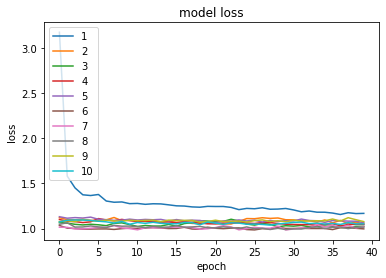

In [31]:
# summarize history for loss

for history in CV_histories[-10:]:
    plt.plot(history.history['loss'])
    
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], loc='upper left')
plt.show()

The result looks like the model gets stable after 20 epochs

### Train and Test the model with Mel-Spectrogram

In [33]:
X_mel = []
X_wav = []
Y = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)

    x_data = melspec_dict[wav_idx]

    X_mel.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X_mel))
print(np.shape(Y))

(11100, 128, 259)
(11100,)


In [40]:
# reshape
X_mel = np.array(X_mel)
X_wav = np.array(X_wav)
Y = np.array(Y)

# X_train = X_train.reshape(X_train.shape[0], max_time, num_mel, 1)
# X_test = X_test.reshape(X_test.shape[0], max_time, num_mel, 1)



print(np.shape(X_mel))
print(np.shape(Y))

(11100, 128, 259)
(11100,)


In [41]:
for train_index, test_index in kf.split(X):
    print("TRAIN: ", X_mel[train_index])
    print("TRAIN: ", X_wav[train_index])
    print("TRAIN: ", Y[test_index])

TRAIN:  [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  

TRAIN:  [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  

TRAIN:  [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  

TRAIN:  [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
TR

In [43]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_melspec = np.shape(X_mel)[1]
max_time = np.shape(X_mel)[2]

In [44]:
input_shape = (num_melspec, max_time)

model_mel = Sequential()

model_mel.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_melspec, max_time)))
model_mel.add(Bidirectional(LSTM(512)))
model_mel.add(Dropout(drop_out_rate))
model_mel.add(Dense(num_dense_unit))
model_mel.add(Dense(128))
model_mel.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model_mel.compile(optimizer=adam, loss="mse", metrics=["mse"])

model_mel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128, 1024)         3162112   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 9,753,089
Trainable params: 9,753,089
Non-trainable params: 0
_________________________________________________________________


In [48]:
from datetime import datetime
logdir = "logs/scalars/melspecCV" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [49]:
CV_mel_mse = []
CV_mel_histories = []
CV_mel_prediction = []

In [51]:
num_epochs = 40

cv_idx = 1
for train_index, test_index in kf.split(X_mel):
    model_name = "../data/CV_rnn_mel_40_CV%d.h5" % (cv_idx)
#     model.load_weights(model_name)
    X_train, X_test = X_mel[train_index], X_mel[test_index]
    X_train_wav, X_test_wav = X_wav[train_index], X_wav[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    history = model_mel.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False,
                       class_weight = None, verbose = 1, validation_data = (X_test, y_test), 
                       callbacks = [tensorboard_callback])
    CV_mel_histories.append(history)
            
    model_mel.save(model_name)
    
    scores = model_mel.evaluate(X_test, y_test, verbose=0)
    CV_mel_mse.append(scores[1])
    y_prediction = model_mel.predict(X_test)
    
    for i in range(len(y_test)):
        result = "%d\t%s\t%d\t%f\n" % (cv_idx, wav_names[X_test_wav[i]], y_test[i], y_prediction[i][0])
#         print(result)
        CV_mel_prediction.append(result)
    
    cv_idx += 1

Train on 9990 samples, validate on 1110 samples
Epoch 1/40
9990/9990 [==============================] - 75s 7ms/step - loss: 2.2527 - mean_squared_error: 2.2527 - val_loss: 2.5782 - val_mean_squared_error: 2.5782
Epoch 2/40
9990/9990 [==============================] - 73s 7ms/step - loss: 2.0070 - mean_squared_error: 2.0070 - val_loss: 1.7237 - val_mean_squared_error: 1.7237
Epoch 3/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.5023 - mean_squared_error: 1.5023 - val_loss: 1.0246 - val_mean_squared_error: 1.0246
Epoch 4/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.3928 - mean_squared_error: 1.3928 - val_loss: 0.9506 - val_mean_squared_error: 0.9506
Epoch 5/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.3424 - mean_squared_error: 1.3424 - val_loss: 0.9561 - val_mean_squared_error: 0.9561
Epoch 6/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.3229 - mean_squared_error: 1.3229 - val_loss: 0.

Epoch 10/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0729 - mean_squared_error: 1.0729 - val_loss: 1.2509 - val_mean_squared_error: 1.2509
Epoch 11/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0845 - mean_squared_error: 1.0845 - val_loss: 1.2828 - val_mean_squared_error: 1.2828
Epoch 12/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0744 - mean_squared_error: 1.0744 - val_loss: 1.2831 - val_mean_squared_error: 1.2831
Epoch 13/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0851 - mean_squared_error: 1.0851 - val_loss: 1.2616 - val_mean_squared_error: 1.2616
Epoch 14/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0510 - mean_squared_error: 1.0510 - val_loss: 1.2867 - val_mean_squared_error: 1.2867
Epoch 15/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0895 - mean_squared_error: 1.0895 - val_loss: 1.2758 - val_mean_squared_error: 1.2758
Epoc

9990/9990 [==============================] - 73s 7ms/step - loss: 1.0534 - mean_squared_error: 1.0534 - val_loss: 1.2407 - val_mean_squared_error: 1.2407
Epoch 20/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0428 - mean_squared_error: 1.0428 - val_loss: 1.2407 - val_mean_squared_error: 1.2407
Epoch 21/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0575 - mean_squared_error: 1.0575 - val_loss: 1.2395 - val_mean_squared_error: 1.2395
Epoch 22/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0395 - mean_squared_error: 1.0395 - val_loss: 1.2764 - val_mean_squared_error: 1.2764
Epoch 23/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0444 - mean_squared_error: 1.0444 - val_loss: 1.2504 - val_mean_squared_error: 1.2504
Epoch 24/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0506 - mean_squared_error: 1.0506 - val_loss: 1.2703 - val_mean_squared_error: 1.2703
Epoch 25/40
9990

9990/9990 [==============================] - 73s 7ms/step - loss: 1.0794 - mean_squared_error: 1.0794 - val_loss: 1.0109 - val_mean_squared_error: 1.0109
Epoch 29/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0767 - mean_squared_error: 1.0767 - val_loss: 1.0101 - val_mean_squared_error: 1.0101
Epoch 30/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0641 - mean_squared_error: 1.0641 - val_loss: 1.0098 - val_mean_squared_error: 1.0098
Epoch 31/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0671 - mean_squared_error: 1.0671 - val_loss: 1.0171 - val_mean_squared_error: 1.0171
Epoch 32/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0573 - mean_squared_error: 1.0573 - val_loss: 1.0147 - val_mean_squared_error: 1.0147
Epoch 33/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0525 - mean_squared_error: 1.0525 - val_loss: 1.0152 - val_mean_squared_error: 1.0152
Epoch 34/40
9990

9990/9990 [==============================] - 73s 7ms/step - loss: 1.0681 - mean_squared_error: 1.0681 - val_loss: 1.1271 - val_mean_squared_error: 1.1271
Epoch 38/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0605 - mean_squared_error: 1.0605 - val_loss: 1.0983 - val_mean_squared_error: 1.0983
Epoch 39/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0697 - mean_squared_error: 1.0697 - val_loss: 1.0927 - val_mean_squared_error: 1.0927
Epoch 40/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0517 - mean_squared_error: 1.0517 - val_loss: 1.0898 - val_mean_squared_error: 1.0898
Train on 9990 samples, validate on 1110 samples
Epoch 1/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0067 - mean_squared_error: 1.0067 - val_loss: 1.3278 - val_mean_squared_error: 1.3278
Epoch 2/40
9990/9990 [==============================] - 73s 7ms/step - loss: 0.9916 - mean_squared_error: 0.9916 - val_loss: 1.3405 - v

Epoch 6/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0408 - mean_squared_error: 1.0408 - val_loss: 1.3887 - val_mean_squared_error: 1.3887
Epoch 7/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0260 - mean_squared_error: 1.0260 - val_loss: 1.3097 - val_mean_squared_error: 1.3097
Epoch 8/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0271 - mean_squared_error: 1.0271 - val_loss: 1.3012 - val_mean_squared_error: 1.3012
Epoch 9/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0550 - mean_squared_error: 1.0550 - val_loss: 1.3549 - val_mean_squared_error: 1.3549
Epoch 10/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0326 - mean_squared_error: 1.0326 - val_loss: 1.3399 - val_mean_squared_error: 1.3399
Epoch 11/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0193 - mean_squared_error: 1.0193 - val_loss: 1.2900 - val_mean_squared_error: 1.2900
Epoch 12

9990/9990 [==============================] - 73s 7ms/step - loss: 1.0297 - mean_squared_error: 1.0297 - val_loss: 1.2557 - val_mean_squared_error: 1.2557
Epoch 16/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0303 - mean_squared_error: 1.0303 - val_loss: 1.3481 - val_mean_squared_error: 1.3481
Epoch 17/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0295 - mean_squared_error: 1.0295 - val_loss: 1.2325 - val_mean_squared_error: 1.2325
Epoch 18/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0133 - mean_squared_error: 1.0133 - val_loss: 1.3296 - val_mean_squared_error: 1.3296
Epoch 19/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0251 - mean_squared_error: 1.0251 - val_loss: 1.3136 - val_mean_squared_error: 1.3136
Epoch 20/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0355 - mean_squared_error: 1.0355 - val_loss: 1.2782 - val_mean_squared_error: 1.2782
Epoch 21/40
9990

9990/9990 [==============================] - 73s 7ms/step - loss: 1.0636 - mean_squared_error: 1.0636 - val_loss: 0.7860 - val_mean_squared_error: 0.7860
Epoch 25/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0718 - mean_squared_error: 1.0718 - val_loss: 0.7309 - val_mean_squared_error: 0.7309
Epoch 26/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0652 - mean_squared_error: 1.0652 - val_loss: 0.7713 - val_mean_squared_error: 0.7713
Epoch 27/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0669 - mean_squared_error: 1.0669 - val_loss: 0.7489 - val_mean_squared_error: 0.7489
Epoch 28/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0736 - mean_squared_error: 1.0736 - val_loss: 0.7630 - val_mean_squared_error: 0.7630
Epoch 29/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0696 - mean_squared_error: 1.0696 - val_loss: 0.7297 - val_mean_squared_error: 0.7297
Epoch 30/40
9990

9990/9990 [==============================] - 73s 7ms/step - loss: 1.0178 - mean_squared_error: 1.0178 - val_loss: 0.9207 - val_mean_squared_error: 0.9207
Epoch 34/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0194 - mean_squared_error: 1.0194 - val_loss: 0.9396 - val_mean_squared_error: 0.9396
Epoch 35/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0232 - mean_squared_error: 1.0232 - val_loss: 0.9315 - val_mean_squared_error: 0.9315
Epoch 36/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0143 - mean_squared_error: 1.0143 - val_loss: 0.9267 - val_mean_squared_error: 0.9267
Epoch 37/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0484 - mean_squared_error: 1.0484 - val_loss: 0.9279 - val_mean_squared_error: 0.9279
Epoch 38/40
9990/9990 [==============================] - 73s 7ms/step - loss: 1.0153 - mean_squared_error: 1.0153 - val_loss: 0.9269 - val_mean_squared_error: 0.9269
Epoch 39/40
9990

In [52]:
for i, mse in enumerate(CV_mse[-10:]):
    print(i + 1, mse)

1 0.8594650799089724
2 1.3125876671559102
3 1.2947366482502705
4 1.0772595652588852
5 1.202253374108323
6 1.4005591244847926
7 1.2510072761827762
8 1.2478395784223402
9 0.7294418357514046
10 0.9379074723870905


In [53]:
with open("../results/mel_10CV.txt", "w") as output:
    for prediction in CV_mel_prediction:
        output.write(prediction)

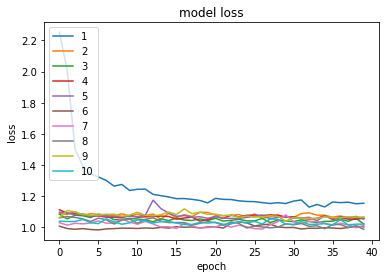

In [54]:
# summarize history for loss

for history in CV_mel_histories[-10:]:
    plt.plot(history.history['loss'])
    
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], loc='upper left')
plt.show()